In [1]:
# Importing necessary libraries for data manipulation and analysis
import numpy as np #Numerical operations and array manipulation
import pandas as pd #Data manipulation and analysis using data frames.

# Importing libraries for data visualization
import matplotlib.pyplot as plt #Plotting library for creating visualizations.
import matplotlib.ticker as mtick #Ticker module for controlling axis ticks in visualizations.
import matplotlib.gridspec as grid_spec #Gridspec module for creating customized subplot layouts.
import seaborn as sns #Statistical data visualization library for enhancing the aesthetics of plots.

# Importing SMOTE for handling imbalanced datasets (Technique for handling imbalanced datasets by oversampling the minority class.)
from imblearn.over_sampling import SMOTE

# Importing scikit-plot for creating various machine learning-related visualizations
import scikitplot as skplt

# Importing machine learning modules for building and evaluating models
from sklearn.pipeline import Pipeline #Tool for streamlining machine learning workflows.
# sklearn.preprocessing.StandardScaler: Standardizes features by removing the mean and scaling to unit variance.
# sklearn.preprocessing.LabelEncoder: Encodes categorical labels with numerical values.
from sklearn.preprocessing import StandardScaler, LabelEncoder
# sklearn.model_selection.train_test_split: Splits the dataset into training and testing sets.
# sklearn.model_selection.cross_val_score: Performs cross-validation to evaluate model performance.
from sklearn.model_selection import train_test_split, cross_val_score

# Importing regression models for predicting continuous outcomes
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Importing classification models for predicting categorical outcomes
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Importing metrics for evaluating classification model performance
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

# Suppressing unnecessary warnings during code execution
import warnings
warnings.filterwarnings('ignore')

# Installing the pywaffle package for creating waffle charts
%pip install pywaffle


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Reading a CSV file named 'healthcare-dataset-stroke-data.csv' into a Pandas DataFrame
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

# Displaying the first few rows of the DataFrame to get an initial overview of the data
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Missing Data

In [3]:
# Checking for missing values in each column of the DataFrame
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

# How can we deal with blanks in our data?

There are many ways. One can simply drop these records, fill the blanks with the mean, the median, or even simply the record before or after the missing value.

But there are other, more unusual ways.

Here I will use a <b> Decision Tree to predict the missing BMI</b>

Other interesting methods to explore could include using K-Nearest-Neighbours to fill the gaps.

In [4]:
# Creating a pipeline for Decision Tree Regression to impute missing 'bmi' values
DT_bmi_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),         # Step 1: Standardize features using StandardScaler
    ('lr', DecisionTreeRegressor(random_state=42))  # Step 2: Decision Tree Regression model
])

# Extracting relevant features from the DataFrame
X = df[['age', 'gender', 'bmi']].copy()

# Mapping categorical 'gender' values to numerical values
X['gender'] = X['gender'].replace({'Male': 0, 'Female': 1, 'Other': -1}).astype(np.uint8)

# Separating rows with missing 'bmi' values for imputation
Missing = X[X['bmi'].isna()]
X = X[~X['bmi'].isna()]
Y = X.pop('bmi')

# Fitting the Decision Tree Regression model to the existing data
DT_bmi_pipe.fit(X, Y)

# Predicting missing 'bmi' values and updating the DataFrame
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age', 'gender']]), index=Missing.index)
df.loc[Missing.index, 'bmi'] = predicted_bmi

In [5]:
# Checking and printing the total count of missing values in the DataFrame
print('Missing values: ', sum(df.isnull().sum()))

Missing values:  0


## Exploring the data

This is the next step after dealing with the missing values in the dataset.

Next, is the EDA stands for Exploratory Data Analysis, which is a crucial step in the data analysis process.

Here, we try to answer different questions like: <br>
Does age makes one more likely to suffer a stroke? What about gender? Or BMI?

These are all questions that can be explored and answered with some data visulization.

First, let's look at the numeric/continuous variable distribtion

In [6]:
# Extracting all columns except 'id' and 'stroke' into the 'variables' list
variables = [variable for variable in df.columns if variable not in ['id','stroke']]

# Selecting specific continuous variables into the 'conts' list
conts = ['age','avg_glucose_level','bmi']

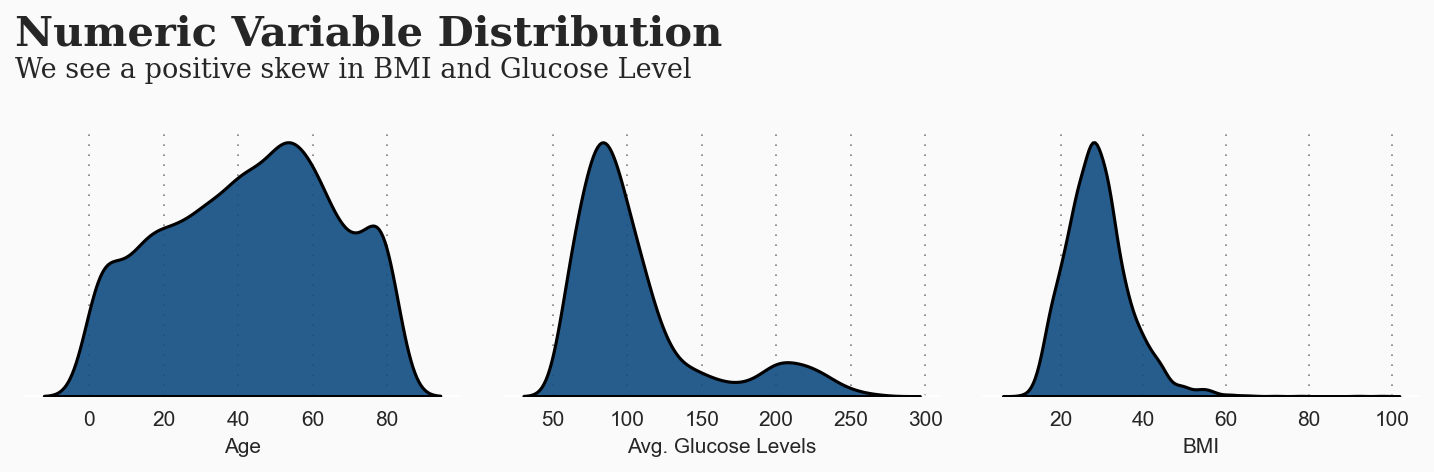

In [7]:
# Setting up the figure with a 1x3 grid
fig = plt.figure(figsize=(12, 12), dpi=150, facecolor='#fafafa')
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

# Setting background color
background_color = "#fafafa"

# Initializing subplots
plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        # Creating individual subplots with a consistent background color
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)

        # Removing y-axis ticks and spines for aesthetics
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)

        # Incrementing plot index
        plot += 1

# Plotting kernel density estimation (KDE) plots for continuous variables
plot = 0
for variable in conts:
    # Creating KDE plots for each continuous variable, with specified styling
    sns.kdeplot(df[variable] ,ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)

    # Adding grid lines for better visualization
    locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))

    # Incrementing plot index
    plot += 1

# Setting individual x-axis labels for each subplot
ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')

# Adding title and annotation for better context
ax0.text(-20, 0.022, 'Numeric Variable Distribution', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-20, 0.02, 'We see a positive skew in BMI and Glucose Level', fontsize=13, fontweight='light', fontfamily='serif')

# Displaying the plot
plt.show()

Let's see how the distribution of our numeric variables is different for those that have strokes, and those that do not.

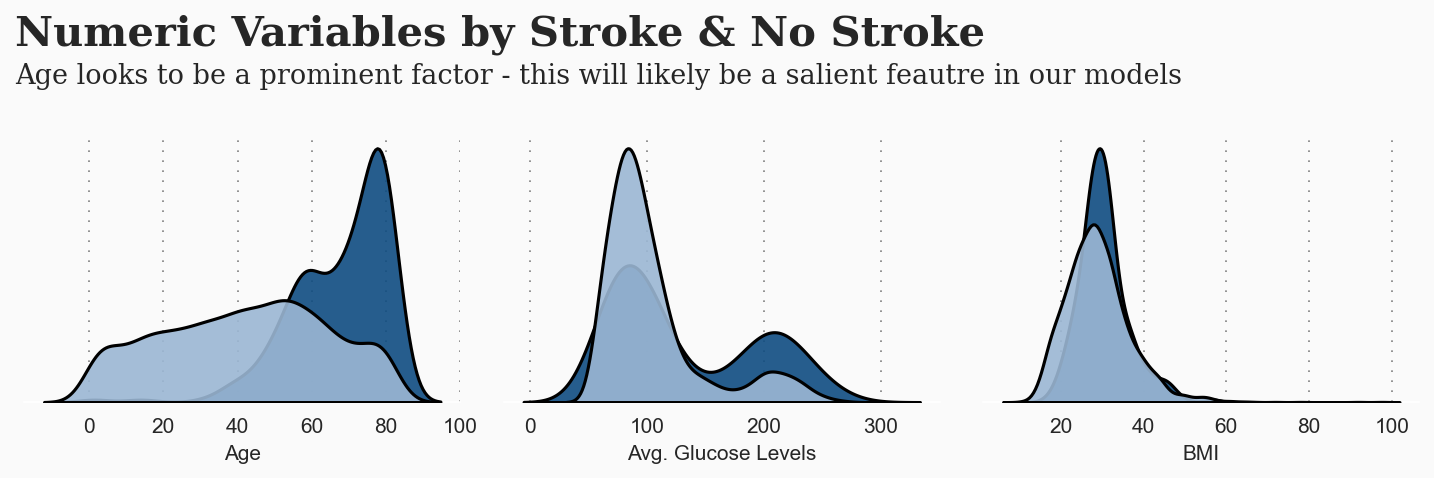

In [8]:
# Setting up the figure with a 1x3 grid and background color
fig = plt.figure(figsize=(12, 12), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

# Initializing subplots
plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        # Creating individual subplots with consistent background color
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)

        # Removing y-axis ticks and spines for aesthetics
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)

        # Incrementing plot index
        plot += 1

# Plotting kernel density estimation (KDE) plots for continuous variables separated by 'stroke' status
plot = 0

s = df[df['stroke'] == 1]
ns = df[df['stroke'] == 0]

for feature in conts:
    # Creating KDE plots for 'stroke' and 'no stroke' groups for each continuous variable
    sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
    sns.kdeplot(ns[feature],ax=locals()["ax"+str(plot)], color='#9bb7d4', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)

    # Adding grid lines for better visualization
    locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))

    # Incrementing plot index
    plot += 1

# Setting individual x-axis labels for each subplot
ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')

# Adding title and annotation for better context
ax0.text(-20, 0.056, 'Numeric Variables by Stroke & No Stroke', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-20, 0.05, 'Age looks to be a prominent factor - this will likely be a salient feautre in our models',
         fontsize=13, fontweight='light', fontfamily='serif')

# Displaying the plot
plt.show()

# Insight

Based on the above plots, it seems clear that Age is a big factor in stroke patients - the older you get the more at risk you are.

Though less obvious, there are also differences in Avg. Glucose Levels and BMI.

Let's explore those variables further...

In [9]:
# Creating two separate DataFrames based on 'stroke' status
str_only = df[df['stroke'] == 1]  # DataFrame for instances with stroke
no_str_only = df[df['stroke'] == 0]  # DataFrame for instances without stroke

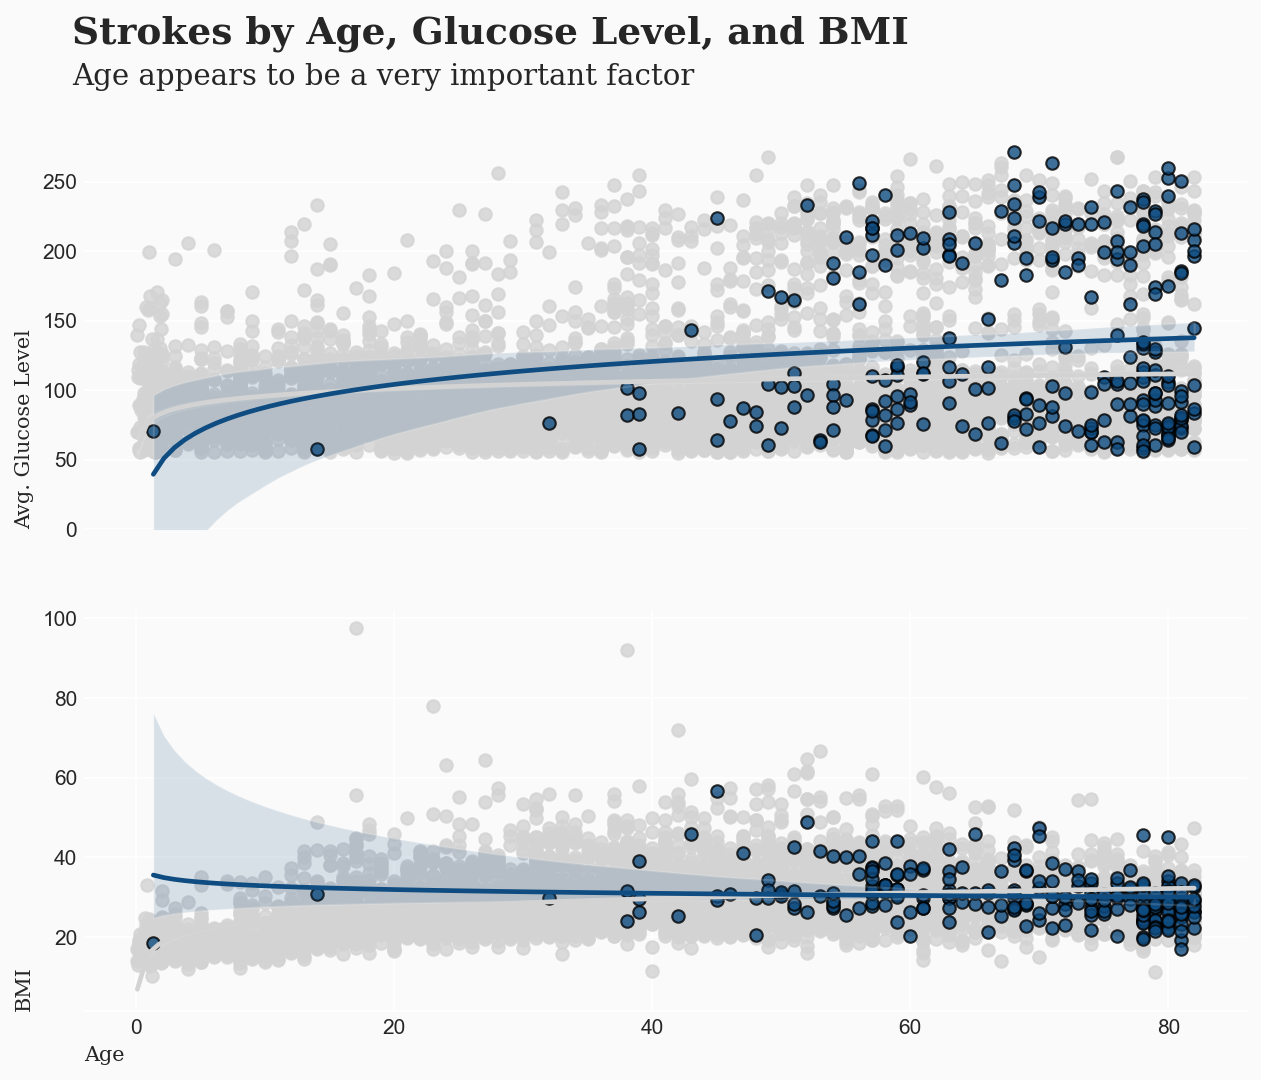

In [10]:
# Setting up figure and axes

# Creating a new figure with a specified size, DPI, and facecolor
fig = plt.figure(figsize=(10, 16), dpi=150, facecolor=background_color)

# Adding a 4x2 grid of subplots with specified spacing
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.5, hspace=0.2)

# Creating two subplots in the grid
ax0 = fig.add_subplot(gs[0, 0:2])
ax1 = fig.add_subplot(gs[1, 0:2])

# Setting facecolor for the subplots
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

# Glucose Level Regression Plot for instances without stroke
sns.regplot(x=no_str_only['age'], y=no_str_only['avg_glucose_level'],
            color='lightgray',
            logx=True,  # Using a logarithmic scale for the x-axis
            ax=ax0)

# Glucose Level Regression Plot for instances with stroke
sns.regplot(x=str_only['age'], y=str_only['avg_glucose_level'],
            color='#0f4c81',
            logx=True,  # Using a logarithmic scale for the x-axis
            scatter_kws={'edgecolors': ['black'], 'linewidth': 1},  # Customizing scatter plot appearance
            ax=ax0)

# Setting y-axis limit to start from 0
ax0.set(ylim=(0, None))
ax0.set_xlabel(" ", fontsize=12, fontfamily='serif')  # Empty x-axis label for aesthetics
ax0.set_ylabel("Avg. Glucose Level", fontsize=10, fontfamily='serif', loc='bottom')

# Styling for Glucose Level Regression Plot
ax0.tick_params(axis='x', bottom=False)  # Removing x-axis ticks for aesthetics
ax0.get_xaxis().set_visible(False)  # Hiding x-axis labels

# Removing unnecessary spines for aesthetics
for s in ['top', 'left', 'bottom']:
    ax0.spines[s].set_visible(False)

# BMI Regression Plot for instances without stroke
sns.regplot(x=no_str_only['age'], y=no_str_only['bmi'],
            color='lightgray',
            logx=True,  # Using a logarithmic scale for the x-axis
            ax=ax1)

# BMI Regression Plot for instances with stroke
sns.regplot(x=str_only['age'], y=str_only['bmi'],
            color='#0f4c81',
            scatter_kws={'edgecolors': ['black'], 'linewidth': 1},  # Customizing scatter plot appearance
            logx=True,  # Using a logarithmic scale for the x-axis
            ax=ax1)

ax1.set_xlabel("Age", fontsize=10, fontfamily='serif', loc='left')
ax1.set_ylabel("BMI", fontsize=10, fontfamily='serif', loc='bottom')

# Removing unnecessary spines for aesthetics
for s in ['top', 'left', 'right']:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)

# Adding title and annotations
ax0.text(-5, 350, 'Strokes by Age, Glucose Level, and BMI', fontsize=18, fontfamily='serif', fontweight='bold')
ax0.text(-5, 320, 'Age appears to be a very important factor', fontsize=14, fontfamily='serif')

# Removing tick marks
ax0.tick_params(axis=u'both', which=u'both', length=0)
ax1.tick_params(axis=u'both', which=u'both', length=0)

# Displaying the plot
plt.show()

As suspected, Age is a big factor, and also has slight relationships with BMI & Avg. Glucose levels.

We might understand intuitively that as <b>Age increases, the risk of having a stroke increases too, but can ve visualise this?

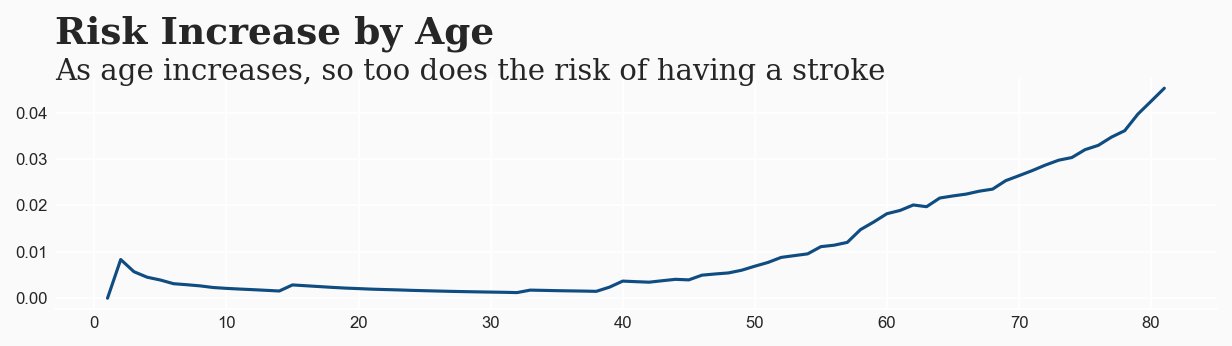

In [11]:
# Create a Matplotlib figure with specified size, resolution, and background color
fig = plt.figure(figsize=(10, 5), dpi=150, facecolor=background_color)

# Set up a 2x1 grid for subplots with custom spacing
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0.11, hspace=0.5)

# Add a subplot to the first position of the grid and set its facecolor to the specified background color
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)

# Convert the 'age' column in the DataFrame to integers for better processing
df['age'] = df['age'].astype(int)

# Calculate stroke rate for each age and store it in the 'rate' list
rate = []
for i in range(df['age'].min(), df['age'].max()):
    rate.append(df[df['age'] < i]['stroke'].sum() / len(df[df['age'] < i]['stroke']))

# Plot the line plot using Seaborn with specified line color and the axis (ax0)
sns.lineplot(data=rate, color='#0f4c81', ax=ax0)

# Styling: Hide top, right, and left spines of the subplot
for s in ["top", "right", "left"]:
    ax0.spines[s].set_visible(False)

# Adjust tick parameters for a cleaner appearance
ax0.tick_params(axis='both', which='major', labelsize=8)
ax0.tick_params(axis=u'both', which=u'both', length=0)

# Add title and subtitle text annotations to the subplot
ax0.text(-3, 0.055, 'Risk Increase by Age', fontsize=18, fontfamily='serif', fontweight='bold')
ax0.text(-3, 0.047, 'As age increases, so too does the risk of having a stroke', fontsize=14, fontfamily='serif')

# Display the created plot
plt.show()

This confirms that The older you get, the more at risk you get.

However, you may have notices the low risk values on the y-axis. This is because the <b>dataset is highly imbalanced.<b>

Only 249 strokes are in our dataset which totals 5000 - around 1 in 20.

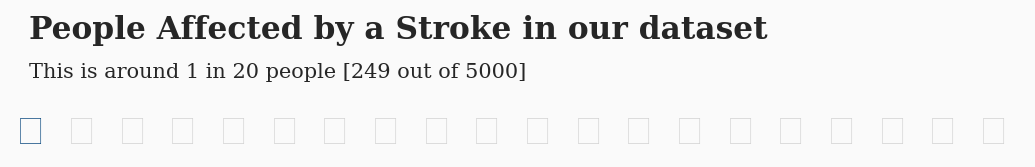

In [12]:
# Import the Waffle class from the pywaffle library
from pywaffle import Waffle

# Create a Matplotlib figure with specified size, resolution, background color, and use the Waffle chart
fig = plt.figure(figsize=(7, 2), dpi=150, facecolor=background_color, FigureClass=Waffle, rows=1,
                 values=[1, 19], colors=['#0f4c81', "lightgray"], characters='⬤', font_size=20, vertical=True)

# Add title and subtitle text annotations to the Waffle chart
fig.text(0.035, 0.78, 'People Affected by a Stroke in our dataset', fontfamily='serif', fontsize=15, fontweight='bold')
fig.text(0.035, 0.65, 'This is around 1 in 20 people [249 out of 5000]', fontfamily='serif', fontsize=10)

# Display the created Waffle chart
plt.show()

This needs to be considered when modelling of course, but also when formulating risk.

Strokes are still relatively rare, we are not saying anything is guaranteed, just that risk is increasing.

In [13]:
# Filter the DataFrame 'no_str_only' to exclude rows where the 'gender' column value is 'Other'
no_str_only = no_str_only[(no_str_only['gender'] != 'Other')]

# General Overview
We've assessed a few variables so far, and gained some powerful insights.

Now, plot several variables in one place, so we can spot interesting trends or features.

Split the data in to 'Stroke' and 'No-Stroke' so as to see if these two populations differ in any meaningful way.

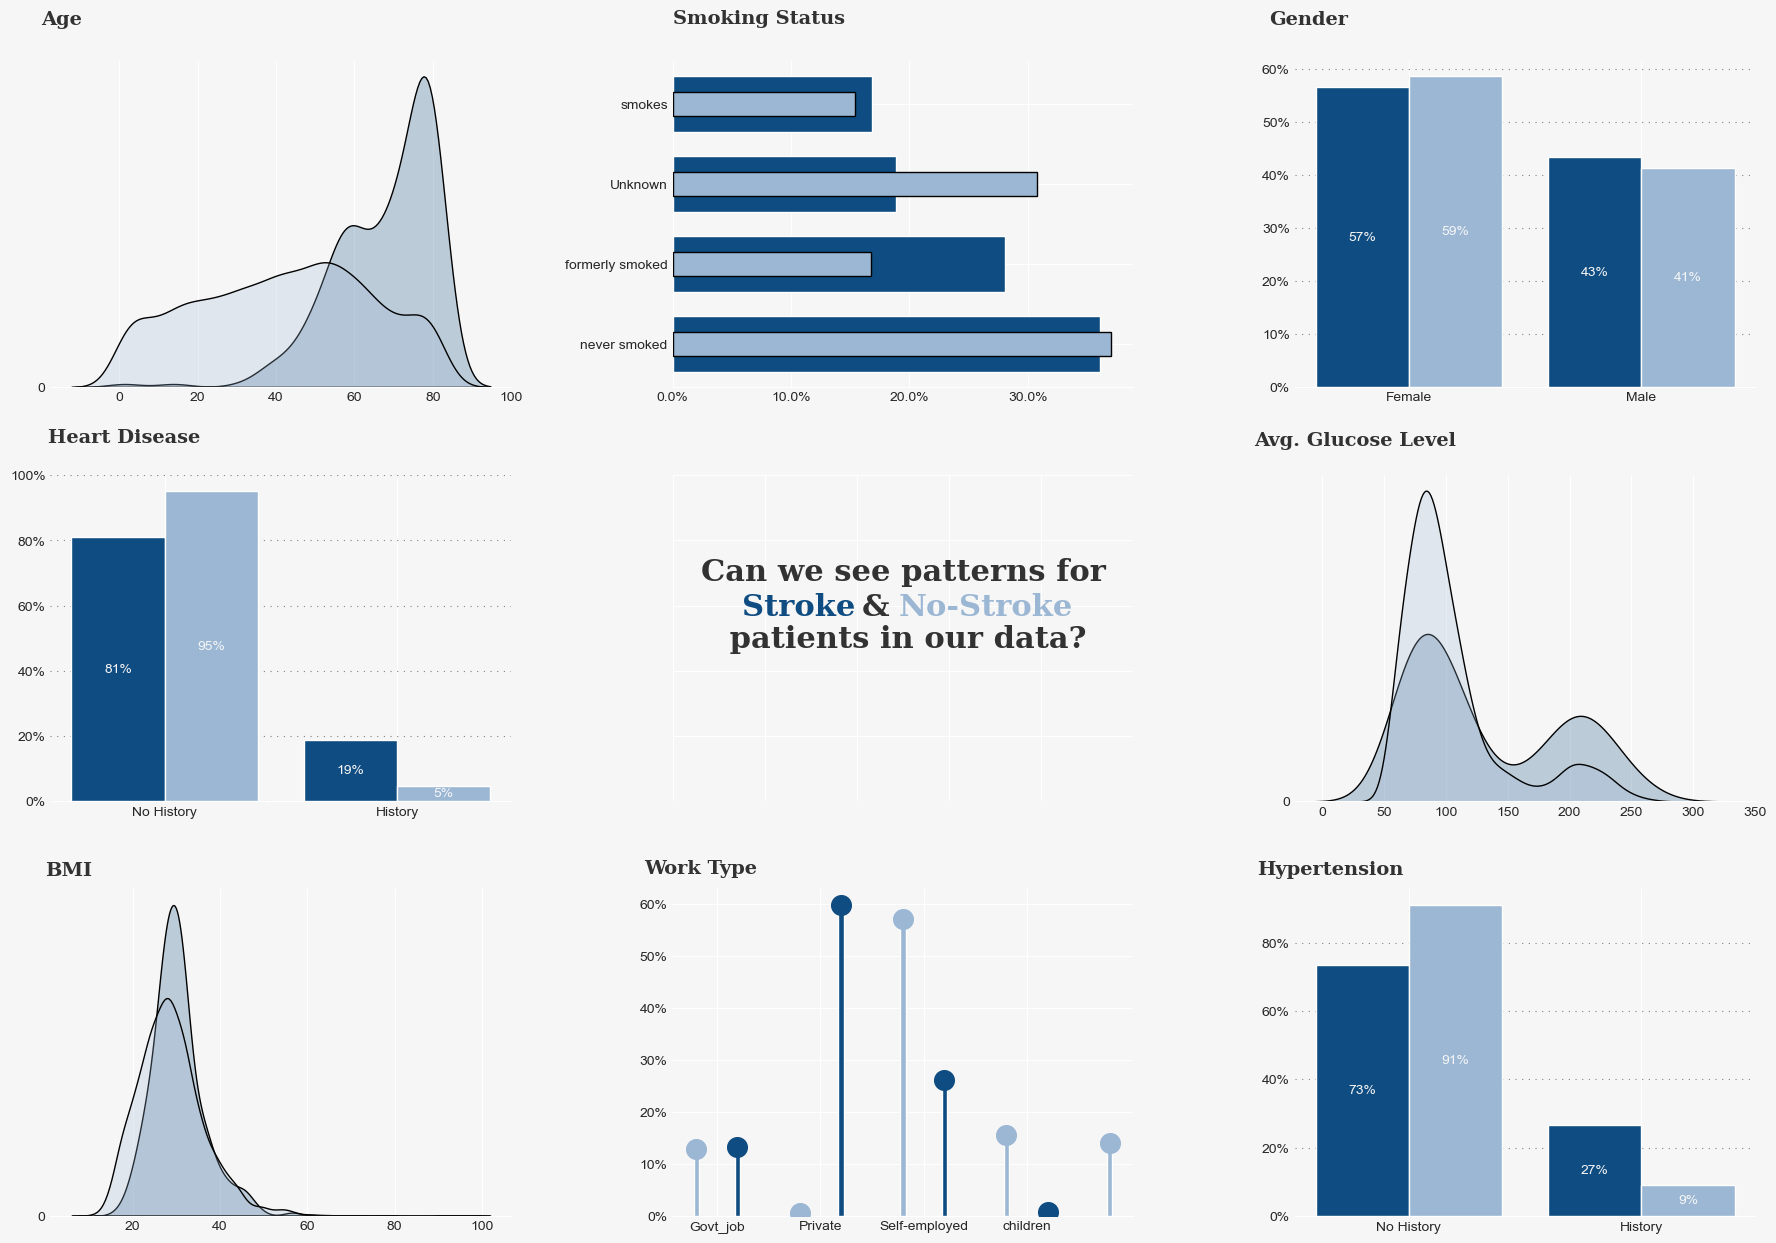

In [14]:
# Create a figure and a grid of subplots
fig = plt.figure(figsize=(22, 15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)  # Set the horizontal and vertical space between subplots

# Define subplots
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])


# Set background color
background_color = "#f6f6f6"
fig.patch.set_facecolor(background_color) # figure background color


# Plots

# Age
# Set grid properties for subplot ax0
ax0.grid(color='gray', linestyle=':', axis='y', zorder=0, dashes=(1, 5))

# Extract 'age' column for positive and negative cases
positive = pd.DataFrame(str_only["age"])
negative = pd.DataFrame(no_str_only["age"])

# Plot Kernel Density Estimates (KDE) for 'age' in positive and negative cases
sns.kdeplot(positive["age"], ax=ax0, color="#0f4c81", shade=True, ec='black', label="positive")
sns.kdeplot(negative["age"], ax=ax0, color="#9bb7d4", shade=True, ec='black', label="negative")

# Customize y-axis ticks
ax0.yaxis.set_major_locator(mtick.MultipleLocator(2))

# Remove y-axis label
ax0.set_ylabel('')

# Remove x-axis label
ax0.set_xlabel('')

# Set title for the subplot
ax0.text(-20, 0.0465, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")


# Smoking
# Calculate value counts and percentages for positive cases
positive_counts = str_only["smoking_status"].value_counts()
positive = pd.DataFrame({"Count": positive_counts})
positive["Percentage"] = (positive["Count"] / positive["Count"].sum()) * 100

# Calculate value counts and percentages for negative cases
negative_counts = no_str_only["smoking_status"].value_counts()
negative = pd.DataFrame({"Count": negative_counts})
negative["Percentage"] = (negative["Count"] / negative["Count"].sum()) * 100

# Set up the subplot and text
ax1.text(0, 4, 'Smoking Status', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

# Plot horizontal bars for positive cases
ax1.barh(positive.index, positive['Percentage'], color="#0f4c81", zorder=3, height=0.7)

# Plot horizontal bars for negative cases
ax1.barh(negative.index, negative['Percentage'], color="#9bb7d4", zorder=3, ec='black', height=0.3)

# Customize x-axis formatting
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())

# Set major locator for x-axis ticks
ax1.xaxis.set_major_locator(mtick.MultipleLocator(10))


# Gender
# For positive cases
positive_counts_gender = str_only["gender"].value_counts()
positive_gender = pd.DataFrame({"Count": positive_counts_gender})
positive_gender["Percentage"] = (positive_gender["Count"] / positive_gender["Count"].sum()) * 100

# For negative cases
negative_counts_gender = no_str_only["gender"].value_counts()
negative_gender = pd.DataFrame({"Count": negative_counts_gender})
negative_gender["Percentage"] = (negative_gender["Count"] / negative_gender["Count"].sum()) * 100

# Set up the subplot and text
x_gender = np.arange(len(positive_gender))
ax2.text(-0.4, 68.5, 'Gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

# Create bar plots
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0, dashes=(1, 5))
ax2.bar(x_gender, height=positive_gender["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax2.bar(x_gender + 0.4, height=negative_gender["Percentage"], zorder=3, color="#9bb7d4", width=0.4)

# Customize x-axis ticks and labels
ax2.set_xticks(x_gender + 0.4 / 2)
ax2.set_xticklabels(positive_gender.index)  # Set the 'gender' values as labels

# Format y-axis as percentages
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))

# Annotate with percentages
for i, j in zip(x_gender, positive_gender["Percentage"]):
    ax2.annotate(f'{j:0.0f}%', xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i, j in zip(x_gender, negative_gender["Percentage"]):
    ax2.annotate(f'{j:0.0f}%', xy=(i + 0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')


# Heart Disease
# For positive cases
positive_counts_heart_disease = str_only["heart_disease"].value_counts()
positive_heart_disease = pd.DataFrame({"Count": positive_counts_heart_disease})
positive_heart_disease["Percentage"] = (positive_heart_disease["Count"] / positive_heart_disease["Count"].sum()) * 100

# For negative cases
negative_counts_heart_disease = no_str_only["heart_disease"].value_counts()
negative_heart_disease = pd.DataFrame({"Count": negative_counts_heart_disease})
negative_heart_disease["Percentage"] = (negative_heart_disease["Count"] / negative_heart_disease["Count"].sum()) * 100

# Set up the subplot and text
x_heart_disease = np.arange(len(positive_heart_disease))
ax3.text(-0.3, 110, 'Heart Disease', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

# Create bar plots
ax3.grid(color='gray', linestyle=':', axis='y', zorder=0, dashes=(1, 5))
ax3.bar(x_heart_disease, height=positive_heart_disease["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax3.bar(x_heart_disease + 0.4, height=negative_heart_disease["Percentage"], zorder=3, color="#9bb7d4", width=0.4)

# Customize x-axis ticks and labels
ax3.set_xticks(x_heart_disease + 0.4 / 2)
ax3.set_xticklabels(['No History', 'History'])

# Format y-axis as percentages
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.yaxis.set_major_locator(mtick.MultipleLocator(20))

# Annotate with percentages
for i, j in zip(x_heart_disease, positive_heart_disease["Percentage"]):
    ax3.annotate(f'{j:0.0f}%', xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i, j in zip(x_heart_disease, negative_heart_disease["Percentage"]):
    ax3.annotate(f'{j:0.0f}%', xy=(i + 0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')


#TITLE
# Remove bottom spine, ticks, and labels
ax4.spines["bottom"].set_visible(False)
ax4.tick_params(left=False, bottom=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])

# Add a central text for the visualization
ax4.text(0.5, 0.6, 'Can we see patterns for\n\n patients in our data?',
         horizontalalignment='center', verticalalignment='center',
         fontsize=22, fontweight='bold', fontfamily='serif', color="#323232")

# Add labels for stroke and no-stroke
ax4.text(0.15, 0.57, "Stroke", fontweight="bold", fontfamily='serif', fontsize=22, color='#0f4c81')
ax4.text(0.41, 0.57, "&", fontweight="bold", fontfamily='serif', fontsize=22, color='#323232')
ax4.text(0.49, 0.57, "No-Stroke", fontweight="bold", fontfamily='serif', fontsize=22, color='#9bb7d4')



# Glucose
# Add grid with specified properties
ax5.grid(color='gray', linestyle=':', axis='y', zorder=0, dashes=(1, 5))

# Extract positive and negative cases for 'avg_glucose_level'
positive = pd.DataFrame(str_only["avg_glucose_level"])
negative = pd.DataFrame(no_str_only["avg_glucose_level"])

# Plot kernel density estimate (KDE) for positive and negative cases
sns.kdeplot(positive["avg_glucose_level"], ax=ax5, color="#0f4c81", ec='black', shade=True, label="positive")
sns.kdeplot(negative["avg_glucose_level"], ax=ax5, color="#9bb7d4", ec='black', shade=True, label="negative")

# Add text label for 'Avg. Glucose Level'
ax5.text(-55, 0.01855, 'Avg. Glucose Level', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

# Set y-axis locator, and remove ylabel and xlabel
ax5.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax5.set_ylabel('')
ax5.set_xlabel('')



# BMI
# Add grid with specified properties
ax6.grid(color='gray', linestyle=':', axis='y', zorder=0, dashes=(1, 5))

# Extract positive and negative cases for 'bmi'
positive = pd.DataFrame(str_only["bmi"])
negative = pd.DataFrame(no_str_only["bmi"])

# Plot kernel density estimate (KDE) for positive and negative cases
sns.kdeplot(positive["bmi"], ax=ax6, color="#0f4c81", ec='black', shade=True, label="positive")
sns.kdeplot(negative["bmi"], ax=ax6, color="#9bb7d4", ec='black', shade=True, label="negative")

# Add text label for 'BMI'
ax6.text(-0.06, 0.09, 'BMI', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

# Set y-axis locator, and remove ylabel and xlabel
ax6.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax6.set_ylabel('')
ax6.set_xlabel('')


# Work Type
# For positive cases
positive_counts_work_type = str_only["work_type"].value_counts()
positive_work_type = pd.DataFrame({"Count": positive_counts_work_type})

# Calculate the percentage for each work type in positive cases
positive_work_type["Percentage"] = (positive_work_type["Count"] / positive_work_type["Count"].sum()) * 100

# Sort the positive work types alphabetically
positive_work_type = positive_work_type.sort_index()

# For negative cases
negative_counts_work_type = no_str_only["work_type"].value_counts()
negative_work_type = pd.DataFrame({"Count": negative_counts_work_type})

# Calculate the percentage for each work type in negative cases
negative_work_type["Percentage"] = (negative_work_type["Count"] / negative_work_type["Count"].sum()) * 100

# Sort the negative work types alphabetically
negative_work_type = negative_work_type.sort_index()

# Plotting code
ax7.bar(negative_work_type.index, height=negative_work_type["Percentage"], zorder=3, color="#9bb7d4", width=0.05)
ax7.scatter(negative_work_type.index, negative_work_type["Percentage"], zorder=3, s=200, color="#9bb7d4")

ax7.bar(np.arange(len(positive_work_type.index)) + 0.4, height=positive_work_type["Percentage"], zorder=3, color="#0f4c81", width=0.05)
ax7.scatter(np.arange(len(positive_work_type.index)) + 0.4, positive_work_type["Percentage"], zorder=3, s=200, color="#0f4c81")

# Format y-axis as percentage and set major locator
ax7.yaxis.set_major_formatter(mtick.PercentFormatter())
ax7.yaxis.set_major_locator(mtick.MultipleLocator(10))

# Set x-axis ticks and labels, and add a text label for 'Work Type'
ax7.set_xticks(np.arange(len(positive_work_type.index)) + 0.4 / 2)
ax7.set_xticklabels(list(positive_work_type.index), rotation=0)
ax7.text(-0.5, 66, 'Work Type', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")


# Hypertension

# For positive cases
# For positive cases
positive_counts_hypertension = str_only["hypertension"].value_counts()
positive_hypertension = pd.DataFrame({"Count": positive_counts_hypertension})

# Calculate the percentage for each hypertension status in positive cases
positive_hypertension["Percentage"] = (positive_hypertension["Count"] / positive_hypertension["Count"].sum()) * 100

# Sort the positive hypertension status values
positive_hypertension = positive_hypertension.sort_index()

# For negative cases
negative_counts_hypertension = no_str_only["hypertension"].value_counts()
negative_hypertension = pd.DataFrame({"Count": negative_counts_hypertension})

# Calculate the percentage for each hypertension status in negative cases
negative_hypertension["Percentage"] = (negative_hypertension["Count"] / negative_hypertension["Count"].sum()) * 100

# Sort the negative hypertension status values
negative_hypertension = negative_hypertension.sort_index()

# Plotting code
x = np.arange(len(positive_hypertension))
ax8.text(-0.45, 100, 'Hypertension', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax8.grid(color='gray', linestyle=':', axis='y', zorder=0, dashes=(1, 5))

# Bar plots for positive and negative hypertension status
ax8.bar(x, height=positive_hypertension["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax8.bar(x + 0.4, height=negative_hypertension["Percentage"], zorder=3, color="#9bb7d4", width=0.4)

# Set x-axis ticks and labels for hypertension status
ax8.set_xticks(x + 0.4 / 2)
ax8.set_xticklabels(['No History', 'History'])

# Format y-axis as a percentage and set major locator
ax8.yaxis.set_major_formatter(mtick.PercentFormatter())
ax8.yaxis.set_major_locator(mtick.MultipleLocator(20))

# Annotate with percentages for both positive and negative cases
for i, j in zip(x, positive_hypertension["Percentage"]):
    ax8.annotate(f'{j:0.0f}%', xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

for i, j in zip(x, negative_hypertension["Percentage"]):
    ax8.annotate(f'{j:0.0f}%', xy=(i + 0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')


# Loop through each subplot and hide specified spines
for spine_location in ["top", "right", "left"]:
    # Iterate over subplot indexes (ax0, ax1, ..., ax8)
    for subplot_index in range(0, 9):
        # Access the subplot dynamically using locals()["ax0"], locals()["ax1"], ..., locals()["ax8"]
        current_subplot = locals()["ax" + str(subplot_index)]
        # Hide the specified spine (top, right, or left) of the current subplot
        current_subplot.spines[spine_location].set_visible(False)

# Loop through each subplot to set face color and tick parameters
for subplot_index in range(0, 9):
    # Access the subplot dynamically using locals()["ax0"], locals()["ax1"], ..., locals()["ax8"]
    current_subplot = locals()["ax" + str(subplot_index)]

    # Set the face color of the subplot
    current_subplot.set_facecolor(background_color)

    # Customize tick parameters (length=0 removes ticks)
    current_subplot.tick_params(axis=u'both', which=u'both', length=0)

    # Set the face color of the subplot
    current_subplot.set_facecolor(background_color)

# Display the finalized plot
plt.show()

# Insights
The plots above are quite enlightening.

As discussed earlier, we again note the importance of Age, amongst other things.

## Model Preparation

In [15]:
# Convert 'gender' column to numerical values
# Replace 'Male' with 0, 'Female' with 1, and 'Other' with -1
# Convert the resulting column to an unsigned 8-bit integer (uint8) for memory efficiency
df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1, 'Other': -1}).astype(np.uint8)

# Convert 'Residence_type' column to numerical values
# Replace 'Rural' with 0 and 'Urban' with 1
# Convert the resulting column to an unsigned 8-bit integer (uint8) for memory efficiency
df['Residence_type'] = df['Residence_type'].replace({'Rural': 0, 'Urban': 1}).astype(np.uint8)

# Convert 'work_type' column to numerical values
# Replace 'Private' with 0, 'Self-employed' with 1, 'Govt_job' with 2, 'children' with -1, 'Never_worked' with -2
# Convert the resulting column to an unsigned 8-bit integer (uint8) for memory efficiency
df['work_type'] = df['work_type'].replace({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': -1, 'Never_worked': -2}).astype(np.uint8)

# Modelling
# Can we predict whether or not an indiviudal will suffer a stroke?
First, we use the SMOTE (Synthetic Minority Over-sampling Technique) to balance our dataset.

Currently, as mentioned above, there are many more negative examples of a stroke and this could hinder our model.

This can be addressed using SMOTE.

# Baseline
For such an imbalanced dataset, a useful baseline can be to beat the 'Null Accuracy', and in our case, since we're looking for the positive ('stroke'), we will take the inverse of that. In other words, always predicting the most common outcome.

For this case, 249/(249+4861) = 0.048

So a good target to beat would be 5%~ for recall for positive stroke patients.

In [16]:
# Calculate and print the inverse of null accuracy
print('Inverse of Null Accuracy: ', 249 / (249 + 4861))

# Calculate and print the null accuracy
print('Null Accuracy: ', 4861 / (4861 + 249))

Inverse of Null Accuracy:  0.0487279843444227
Null Accuracy:  0.9512720156555773


In [17]:
# Selecting features ('gender', 'age', 'hypertension', 'heart_disease', 'work_type', 'avg_glucose_level', 'bmi')
# and the target variable ('stroke') from the DataFrame to create the input (X) and output (y) datasets.
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'work_type', 'avg_glucose_level', 'bmi']]
y = df['stroke']

# Importing the 'train_test_split' function from scikit-learn to split the dataset into training and testing sets.
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets.
# The 'train_size' parameter is set to 0.3, indicating that 30% of the data will be used for training.
# The 'random_state' parameter is set to 42 for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

In [18]:
# Displaying the first two rows of the DataFrame X_test.
X_test.head(2)

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi
4688,0,31,0,0,1,64.85,23.0
4478,0,40,0,0,1,65.29,28.3


In [19]:
# Creating an instance of the SMOTE (Synthetic Minority Over-sampling Technique) class.
oversample = SMOTE()

# Applying SMOTE to the training data to balance the class distribution.
# X_train: Feature variables of the training set
# y_train.ravel(): Target variable of the training set, flattened to a 1D array
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

Our data is now equal

# Models
We will model Random Forest, SVM, and Logisitc Regression for this classificatioin task.

In addition, we will utilise 10 fold cross validation.

In [20]:
# Random Forest Classifier pipeline
rf_pipeline = Pipeline(steps=[('scale', StandardScaler()), ('RF', RandomForestClassifier(random_state=42))])

# Support Vector Machine Classifier pipeline
svm_pipeline = Pipeline(steps=[('scale', StandardScaler()), ('SVM', SVC(random_state=42))])

# Logistic Regression Classifier pipeline
logreg_pipeline = Pipeline(steps=[('scale', StandardScaler()), ('LR', LogisticRegression(random_state=42))])

In [21]:
# Cross-validation for Random Forest Classifier
rf_cv = cross_val_score(rf_pipeline, X_train_resh, y_train_resh, cv=10, scoring='f1')

# Cross-validation for Support Vector Machine Classifier
svm_cv = cross_val_score(svm_pipeline, X_train_resh, y_train_resh, cv=10, scoring='f1')

# Cross-validation for Logistic Regression Classifier
logreg_cv = cross_val_score(logreg_pipeline, X_train_resh, y_train_resh, cv=10, scoring='f1')

In [22]:
# Print Mean F1 Scores for each classifier
print('Mean f1 scores:')
print('Random Forest mean :', cross_val_score(rf_pipeline, X_train_resh, y_train_resh, cv=10, scoring='f1').mean())
print('SVM mean :', cross_val_score(svm_pipeline, X_train_resh, y_train_resh, cv=10, scoring='f1').mean())
print('Logistic Regression mean :', cross_val_score(logreg_pipeline, X_train_resh, y_train_resh, cv=10, scoring='f1').mean())

Mean f1 scores:
Random Forest mean : 0.9378291763168056
SVM mean : 0.8750237994568663
Logistic Regression mean : 0.8275288982657916


# Random Forest performed the best
Often, tree methods will be the model of choice.

# Now let's try it on the unseen negative data

In [23]:
# Fit the Random Forest, SVM, and Logistic Regression pipelines on the resampled training data
rf_pipeline.fit(X_train_resh, y_train_resh)
svm_pipeline.fit(X_train_resh, y_train_resh)
logreg_pipeline.fit(X_train_resh, y_train_resh)

# Make predictions using the trained models on the test set
rf_pred = rf_pipeline.predict(X_test)
svm_pred = svm_pipeline.predict(X_test)
logreg_pred = logreg_pipeline.predict(X_test)

# Calculate confusion matrices for each model's predictions
rf_cm = confusion_matrix(y_test, rf_pred)
svm_cm = confusion_matrix(y_test, svm_pred)
logreg_cm = confusion_matrix(y_test, logreg_pred)

# Calculate F1 scores for each model's predictions
rf_f1 = f1_score(y_test, rf_pred)
svm_f1 = f1_score(y_test, svm_pred)
logreg_f1 = f1_score(y_test, logreg_pred)

In [24]:
# Print the mean F1 scores for each model
print('Mean f1 scores:')
print('RF mean :', rf_f1)
print('SVM mean :', svm_f1)
print('LR mean :', logreg_f1)

Mean f1 scores:
RF mean : 0.17142857142857143
SVM mean : 0.1617933723196881
LR mean : 0.19521178637200734


In [25]:
# Import necessary functions from scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Print the classification report for the Random Forest model
print(classification_report(y_test, rf_pred))

# Print the accuracy score for the Random Forest model
print('Accuracy Score: ', accuracy_score(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3404
           1       0.13      0.26      0.17       173

    accuracy                           0.88      3577
   macro avg       0.54      0.58      0.55      3577
weighted avg       0.92      0.88      0.90      3577

Accuracy Score:  0.8783897120492032


# Good accuracy, poor recall
We will try using a grid search to find the optimal parameters for our Random Forest

In [26]:
# Importing the necessary module
from sklearn.model_selection import GridSearchCV

# Defining lists of values for hyperparameters
n_estimators = [64, 100, 128, 200]
max_features = [2, 3, 5, 7]
bootstrap = [True, False]

# Creating a parameter grid as a dictionary
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'bootstrap': bootstrap}

# Create an instance of the RandomForestClassifier
rfc = RandomForestClassifier()

In [27]:
# Instantiate RandomForestClassifier with initial hyperparameter values
# max_features: The number of features to consider when looking for the best split, set to 2.
# n_estimators: The number of trees in the forest, set to 100.
# bootstrap: Whether bootstrap samples are used when building trees, set to True.
rfc = RandomForestClassifier(max_features=2, n_estimators=100, bootstrap=True)

# Train (fit) the RandomForestClassifier on the oversampled training data
rfc.fit(X_train_resh, y_train_resh)

# Make predictions on the test set using the trained model
rfc_tuned_pred = rfc.predict(X_test)

In [28]:
# Print the classification report, which includes precision, recall, and F1-score.
# The classification report is a useful summary of the model's performance on different classes.
print(classification_report(y_test, rfc_tuned_pred))

# Print the accuracy score, which represents the overall accuracy of the model on the test set.
# It is the ratio of correctly predicted instances to the total instances.
print('Accuracy Score: ', accuracy_score(y_test, rfc_tuned_pred))

# Print the F1 score, which is the harmonic mean of precision and recall.
# F1 score provides a balance between precision and recall and is commonly used in imbalanced datasets.
print('F1 Score: ', f1_score(y_test, rfc_tuned_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      3404
           1       0.13      0.24      0.17       173

    accuracy                           0.88      3577
   macro avg       0.54      0.58      0.55      3577
weighted avg       0.92      0.88      0.90      3577

Accuracy Score:  0.8817444786133631
F1 Score:  0.16568047337278105


# What about Logistic Regression?
Logistic Regression had the highest f1 score above, so perhaps we can tune that for better results.